<h1> Sharp Interface Multiphase Model with Stokes Dissipation </h1>

In [6]:
print("test")
!mkdir xsFSIc_G10_1_2_2_h5/

test
mkdir: cannot create directory ‘xsFSIc_G10_1_2_2_h5/’: File exists


In [108]:
# xsFSIc_G10_0_4_2 done
# xsFSIc_G10_1_1_2 done
# xsFSIc_G10_1_2_2 done
# xsFSIc_G10_1_4_1 done
# xsFSIc_G10_1_4_2 done
# xsFSIc_G10_1_4_3 not needed
# xsFSIc_G10_2_4_1 done
# xsFSIc_G10_2_4_2 done
# xsFSIc_G10_2_4_3 done
# xsFSIc_G10_3_4_2 done new
# xsFSIc_G10_2_2_2 done new
# nuni,taufac,FEu_DEG

from dolfin import *
from mshr import *
from ufl import cofac
import matplotlib.pyplot as plt
import numpy as np
from os import mkdir,system

### DEFINE PARAMETERS ###
fac            = 2   
r              = 0.5         # in mum (divided by H)
h              = 1.0         # in mum (divided by H)
H1             = 1.0         # in mum (divided by H)
H2             = 2.0         # in mum (divided by H)

G2             = 10.0        # solid
G1             = 0.0         # liquid
G0             = 0.0         # air

# Discretization
mu             = 1.00           # Stokes Dissipation
kappa          = 1e+4           # compressibility

nuni           = 2
taufac         = 2
FEu_DEG        = 2

FEp_DEG        = 1
FEs_DEG        = 2
FE_quad        = 7

dt             = 0.005 / taufac
dt0            = 0.050
n_steps        = 250 * taufac

sigma_s = 0.5
sigma_l = 2.5
sigma_a = 3.5

sigma_sa = (sigma_s + sigma_a)#*(3/(2*sqrt(2)))*(3/(2*sqrt(2)))
sigma_sl = (sigma_s + sigma_l)#*(3/(2*sqrt(2)))*(3/(2*sqrt(2)))
sigma_la = (sigma_l + sigma_a)#*(3/(2*sqrt(2)))*(3/(2*sqrt(2)))

# Output
filepath_vtu   = 'xsFSIc_G10_'+str(nuni)+'_'+str(taufac)+'_'+str(FEu_DEG)+'/'
filepath_h5    = 'xsFSIc_G10_'+str(nuni)+'_'+str(taufac)+'_'+str(FEu_DEG)+'_h5/'
filebase_vtu   = 'sol'
filebase_h5    = 'state'

# Solver
NEWTON_tol     = 1e-7

# Switches
RADIAL         = True
INCOMPRESSIBLE = False

# General functionality
try:
    mkdir(filepath_h5)
    print("created "+filepath_h5)
except:
    print("could not create "+filepath_h5)

system('cp sharp-interface-model-benchmark-stokes.ipynb ' + filepath_h5)
    
# Some helper function for output 
from IPython.display import HTML, display
def progress(t,value, max=100):
    return HTML("""
        Iterations: {value} of {max}, Time: {t:.2e} 
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max, t=t))

created xsFSIc_G10_2_2_2_h5/


6867
0.49999999999999994  ==  0.5
0.49999999999999994  ==  0.5
0.7853793743158479  ==  0.7853981633974483


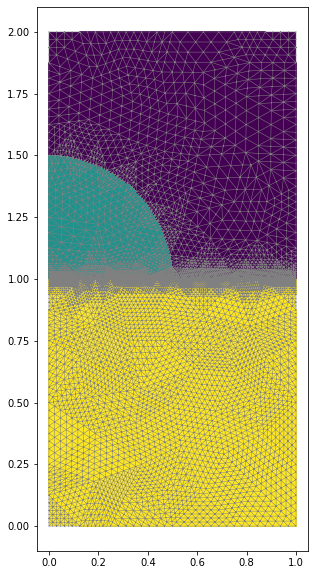

In [109]:
parameters["refinement_algorithm"] = "plaza_with_parent_facets"

# Define 2D geometry
domain = Rectangle(Point(0,0), Point(H1,H2))
domain.set_subdomain(1, Circle(Point(0, h), r, 32*fac))
domain.set_subdomain(2, Rectangle(Point(0,0),Point(H1,h)))

# Generate and plot mesh
mesh = generate_mesh(domain, 4*fac)
tol = 1e-2 #0.01/(H*fac) #1e-1 #3

class interface_sl(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], h , tol) and x[0] < (r + tol)

class interface_sa(SubDomain):
    def inside(self, x, on_boundary):  
        return near(x[1], h , tol) and x[0] > (r - tol)

class interface_la(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0]**2+(x[1]-h)**2,r**2, tol) and x[1] > (h - tol)

# Convert subdomains to mesh function for plotting
subdomain_marker = MeshFunction("size_t", mesh,mesh.topology().dim()  ,mesh.domains())
interface_marker = MeshFunction("size_t", mesh,mesh.topology().dim()-1,0)

gamma_sl = interface_sl()
gamma_sa = interface_sa()
gamma_la = interface_la()

gamma_sl.mark(interface_marker, 1)
gamma_sa.mark(interface_marker, 2)
gamma_la.mark(interface_marker, 3)

p = Point(r,h)
R0 = r 

def project_to_disc(mesh):
    yy0 = 1.0
    coords = mesh.coordinates()
    for c in edges(mesh):
        if interface_marker[c] == 3:
            for v in vertices(c):
                xx = v.point()[0]
                yy = v.point()[1]
                ii = v.index()
                rr = np.sqrt(xx**2 + (yy-1)**2)
                coords[ii,0] =             xx*r/rr
                coords[ii,1] = yy0 + (yy-yy0)*r/rr

# Mark cells for refinement
for k in range(1):
    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
        #if c.midpoint().distance(p) < R0:
        #    cell_markers[c] = True    
        #else:
        #    cell_markers[c] = False
        if c.midpoint()[1] < 1:
            cell_markers[c] = True
        else:
            cell_markers[c] = False
    R0 = R0/2
    mesh = refine(mesh, cell_markers)    
    subdomain_marker = adapt(subdomain_marker, mesh)
    interface_marker = adapt(interface_marker, mesh)
    
for k in range(2):
    refine_interface_marker = MeshFunction("bool", mesh,mesh.topology().dim()-1,False)
    gamma_sl.mark(refine_interface_marker, True)
    gamma_sa.mark(refine_interface_marker, True)
    mesh = refine(mesh,refine_interface_marker)
    subdomain_marker = adapt(subdomain_marker, mesh)
    interface_marker = adapt(interface_marker, mesh)
    
for k in range(nuni):
    mesh = refine(mesh)
    subdomain_marker = adapt(subdomain_marker, mesh)
    interface_marker = adapt(interface_marker, mesh)    

project_to_disc(mesh)
   
n  = FacetNormal(mesh)
dS = Measure("dS", domain=mesh, subdomain_data=interface_marker)
dx = Measure("dx", domain=mesh, subdomain_data=subdomain_marker)
R  = SpatialCoordinate(mesh)

def output_state(i,mesh,q,fname, t=0):
    ff1 = open(fname + '.time','w')
    ff1.write(str(i)+' '+str(t)+'\n')
    ff1.close()

    ff2=HDF5File(mesh.mpi_comm(),fname  + '.h5', 'w')
    ff2.write(mesh,"mesh")   
    ff2.write(q,"q",t)
    ff2.write(subdomain_marker,"subdomain_marker")
    ff2.write(interface_marker,"interface_marker")
    ff2.close()
    
plt.figure(figsize=(10,10))
plot(subdomain_marker)
plot(mesh,linewidth=0.5)
print(mesh.num_vertices())
#plt.xlim([0,0.2])
#plt.ylim([0.9,1.2])

print(assemble(Constant(1)*dS(1))," == ",r)
print(assemble(Constant(1)*dS(2))," == ",H1-r)
print(assemble(Constant(1)*dS(3))," == ",pi*r*0.5)

def get_volumes(q):
    if INCOMPRESSIBLE:
        v, lambda1 = split(q)      # Current solution
    else:
        v     = q
    if RADIAL: 
        d = 3
    else:
        d = 2
    I       = Identity(d)
    F       = I + vector_grad_axi(v)
    if RADIAL: 
        measure = 2*pi*R[0]*det(F)
    else:
        measure = det(F)

    v0 = assemble(measure*dx(0))
    v1 = assemble(measure*dx(1))
    v2 = assemble(measure*dx(2))
    
    return v0,v1,v2

0.5 1.5
0.22360679775 1.22360679775
0.22360679775 1.22360679775
0.22360679775 1.22360679775
0.22360679775 1.22360679775
0.22360679775 1.22360679775


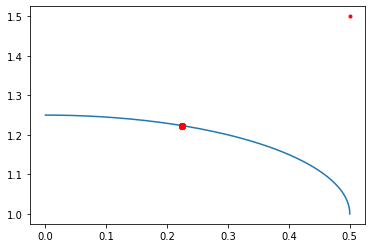

In [22]:
import numpy as np
import matplotlib.pyplot as plt

xx = 0.5
yy = 1.5
h  = 1.0
rx = 0.5
rz = 0.25

def pproject(xx,yy,h,rx,rz):  
    phi = np.arctan2((yy-h)*rx/rz,xx)   
    x1 =     rx * np.cos(phi)
    y1 = h + rz * np.sin(phi)    
    return x1,y1

phi = np.linspace(0,np.pi/2,128)
plt.plot(rx*np.cos(phi),h+rz*np.sin(phi))


plt.plot(xx,yy,'r.')
print(xx,yy)
for i in range(5):
    xx,yy=pproject(xx,yy,h,rx,rz)
    plt.plot(xx,yy,'ro')
    print(xx,yy)


In [110]:
sigma_s = 0.5
sigma_l = 2.5
sigma_a = 3.5

sigma_sa = (sigma_s + sigma_a)#*(3/(2*sqrt(2)))
sigma_sl = (sigma_s + sigma_l)#*(3/(2*sqrt(2)))
sigma_la = (sigma_l + sigma_a)#*(3/(2*sqrt(2)))

print(r)
F_exact = sigma_sl*pi*r**2 + sigma_sa*pi*(1.0**2-r**2) + 2*pi*r**2*sigma_la
print(F_exact / (2*pi))
print((3/(2*sqrt(2))))

0.5
3.375
1.0606601717798212


In [111]:
parameters["form_compiler"]["optimize"] = True
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = FE_quad

def get_space(mesh):
  if FEu_DEG>0: # Standard element
    Pv = VectorElement("P", mesh.ufl_cell(), FEu_DEG)
  else: # Mini element
    Pk = FiniteElement("Lagrange", mesh.ufl_cell(), -FEu_DEG)
    B  = FiniteElement("Bubble",   mesh.ufl_cell(), 3)
    Pv = VectorElement(NodalEnrichedElement(Pk, B))  

  if FEp_DEG>0:
    R  = FiniteElement("P", mesh.ufl_cell(), FEp_DEG)
  else:
    R  = FiniteElement("DG", mesh.ufl_cell(), -FEp_DEG)

  if INCOMPRESSIBLE:
      V   = FunctionSpace(mesh, MixedElement([Pv, R])) 
  else:
      V   = FunctionSpace(mesh,Pv)
  return V

def get_scalar(mesh):
  Ps = FiniteElement("P", mesh.ufl_cell(), FEs_DEG)
  S = FunctionSpace(mesh, Ps)
  return S

def get_vector(mesh): 
  if FEu_DEG>0: # Standard element
      Pv = VectorElement("P", mesh.ufl_cell(), FEu_DEG)
  else: # Mini element
      Pk = FiniteElement("Lagrange", mesh.ufl_cell(), -FEu_DEG)
      B  = FiniteElement("Bubble",   mesh.ufl_cell(), 3)
      Pv = VectorElement(NodalEnrichedElement(Pk, B))     
  V = FunctionSpace(mesh, Pv)
  return V

noslip   = Constant((0, 0)) 
noslip1d = Constant(0)

def boundary_bot1(x, on_boundary):
    return on_boundary and near(x[0], 0, tol)
def boundary_bot2(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)
def boundary_bot3(x, on_boundary):
    return on_boundary and near(x[0], H1, tol)
def boundary_bot4(x, on_boundary):
    return on_boundary and near(x[1], H2, tol)

def get_BC(W):   
  if INCOMPRESSIBLE:
    bc1 = DirichletBC(W.sub(0).sub(0) , noslip1d , boundary_bot1)
    bc2 = DirichletBC(W.sub(0)        , noslip   , boundary_bot2)
    bc3 = DirichletBC(W.sub(0).sub(0) , noslip1d , boundary_bot3)
    bc4 = DirichletBC(W.sub(0)        , noslip   , boundary_bot4)
  else:
    bc1 = DirichletBC(W.sub(0), noslip1d, boundary_bot1)
    bc2 = DirichletBC(W       , noslip  , boundary_bot2)
    bc3 = DirichletBC(W.sub(0), noslip1d, boundary_bot3)
    bc4 = DirichletBC(W       , noslip  , boundary_bot4)      
  bc = [bc1,bc2,bc3,bc4]
  return bc

def scalar_grad_axi(u):
    if RADIAL:
        return as_vector([u.dx(0), 0, u.dx(1)])
    else:
        return grad(u)
  
def vector_grad_axi(v):
    if RADIAL:
        return as_tensor([[v[0].dx(0), 0, v[0].dx(1)], [0, v[0]/R[0], 0],
                                    [v[1].dx(0), 0, v[1].dx(1)]])
    else:
        return grad(v)
    
def expand_vector(u):
    if RADIAL:
        return as_vector([u[0],0,u[1]])
    else:
        return u
    
def incremental_minimization(old_q, tau):
    W = old_q.function_space()
    q, dq = Function(W), TestFunction(W)

    if INCOMPRESSIBLE:
        v, lambda1 = split(q)      # Current solution
        old_v,_    = split(old_q)  # Old solution
        dv,_       = split(dq)     # Test functions
    else:
        v     = q
        dv    = dq
        old_v = old_q

    if RADIAL: 
        d = 3
    else:
        d = 2

    I       = Identity(d)
    F       = I + vector_grad_axi(v)
    old_F   = I + vector_grad_axi(old_v)
    C       = F.T*F        # (right) Cauchy-Green tensor

    # Stored strain energy density (compressible neo-Hookean model)
    e0 = G0/2 * tr(C-I)*R[0] 
    e1 = G1/2 * tr(C-I)*R[0] 
    e2 = G2/2 * tr(C-I)*R[0] 

    if INCOMPRESSIBLE:
        e_comp = R[0]*lambda1*(det(F)-1)
    else:
        e_comp = R[0]*kappa*(det(F)-1)**2

    #############################
    # DEFINE PROBLEM via RESIDUAL
    #############################
    
    nn   = expand_vector(n('+'))
    dn   = cofac(F)('+')*nn # n('+')
    Area = sqrt(inner(dn,dn))*R[0]
    E  = ( e0*dx(0) + e1*dx(1) + e2*dx(2) + e_comp*dx )
    
    E += sigma_sl * Area * dS(1) 
    E += sigma_sa * Area * dS(2) 
    E += sigma_la * Area * dS(3) 

    dot_v = (v-old_v) / tau

    Res  = derivative(E, q, dq)
    Res += mu*inner(vector_grad_axi(dot_v)*inv(old_F), vector_grad_axi(dv)*inv(old_F))*det(old_F)*R[0]*dx
    
    # Solve
    bc      = get_BC(W)
    q.assign(old_q)

    
    
    solve(Res==0,q,bc,solver_parameters={"newton_solver":{"linear_solver"      : "mumps", 
                                                          "absolute_tolerance" : NEWTON_tol,
                                                          "maximum_iterations" : 10 }})
    
    E_elast    = assemble(e0*dx(0)+e1*dx(1)+e2*dx(2))
    E_comp     = assemble(e_comp*dx)
    E_surf     = assemble(sigma_sl*Area*dS(1) + sigma_sa*Area*dS(2) + sigma_la*Area*dS(3))
    
    dot_v_norm = assemble(inner(dot_v,dot_v)*dx)
    
    return q,dot_v_norm,E_elast,E_comp,E_surf

# Initial flow conformant with boundary conditions 
t       = 0
if INCOMPRESSIBLE:
    initial = Expression(( "0", "0","0"), degree=4, t=0.0)
else:
    initial = Expression(( "0", "0"), degree=4, t=0.0)
    
W       = get_space(mesh)
file1   = File(filepath_vtu + filebase_vtu + "_disp.pvd")
file2   = File(filepath_vtu + filebase_vtu + "_ind.pvd")
out     = display(progress(t,0, n_steps), display_id=True)

if RADIAL:
    R = SpatialCoordinate(mesh)
else:
    R = Constant((1.0,1.0))

# initial data
old_q   = interpolate(initial, W)
old_q.rename("disp","disp")
subdomain_marker.rename("psi","psi")
output_state(0,mesh,old_q,filepath_h5 + filebase_h5 + '_initial', t)

file1 << (old_q,t)
file2 << (subdomain_marker,t)

# initial small step
dt_initial = 0.5e-7
dt_adapt = dt_initial

E1 = []
E2 = []
E3 = []
vels = []
tims = []

fx1 = open(filepath_vtu + 'times.txt','w')
fx2 = open(filepath_vtu + 'e_elast.txt'   ,'w')
fx3 = open(filepath_vtu + 'e_comp.txt'   ,'w')
fx4 = open(filepath_vtu + 'e_surf.txt'   ,'w')

q,dqdt,E_elast,E_comp,E_surf = incremental_minimization(old_q, dt_adapt)
t        = t + dt_adapt

vels.append(dqdt)

fx1.write(str(t)       +'\n')
fx2.write(str(E_elast) +'\n')
fx3.write(str(E_comp)  +'\n')
fx4.write(str(E_surf)  +'\n')

tims.append(t)
E1.append(E_elast)
E2.append(E_comp)
E3.append(E_surf)

old_q.assign(q)
    
file1 << (old_q,t)
file2 << (subdomain_marker,t)
m = 0

for i in range(0,n_steps+1):
    
    out.update(progress(t,i, n_steps))
    
    # adjust time-step size
    if (i<20):
        dt_adapt = dt / 10
    else:
        dt_adapt = dt
        
    # incremental step
    q,dqdt,E_elast,E_comp,E_surf = incremental_minimization(old_q, dt_adapt)  
    t += dt_adapt
    vels.append(dqdt)
    tims.append(t)
    E1.append(E_elast)
    E2.append(E_comp)
    E3.append(E_surf)
    fx1.write(str(t)       +'\n')
    fx2.write(str(E_elast) +'\n')
    fx3.write(str(E_comp)  +'\n')
    fx4.write(str(E_surf)  +'\n')

    old_q.assign(q)
    
    if near(t % dt0,0,dt/100): 
        print('time = ',t)
        # output h5
        m = m + 1
        output_state(i,mesh,q,filepath_h5 + filebase_h5 + '_' + str(m), t)    
    
        # ouput pvd/vtu
        old_q.rename("disp","disp")
        tmp = Function(q.function_space())
        tmp.assign(-q)
        ALE.move(mesh,q)
        file1 << (q,t)
        file2 << (subdomain_marker,t)
        ALE.move(mesh,tmp) 
        
fx1.close()
fx2.close()
fx3.close()
fx4.close()

time =  0.05000005000000001
time =  0.10000005000000005
time =  0.15000005000000008
time =  0.20000005000000012
time =  0.25000005000000014
time =  0.3000000500000002
time =  0.35000005000000023
time =  0.4000000500000003
time =  0.4500000500000003
time =  0.5000000500000004
time =  0.5500000499999993
time =  0.6000000499999982
time =  0.6500000499999972
time =  0.7000000499999961
time =  0.750000049999995
time =  0.800000049999994
time =  0.8500000499999929
time =  0.9000000499999918
time =  0.9500000499999908
time =  1.0000000499999897
time =  1.0500000499999886
time =  1.1000000499999876
time =  1.1500000499999865
time =  1.2000000499999854


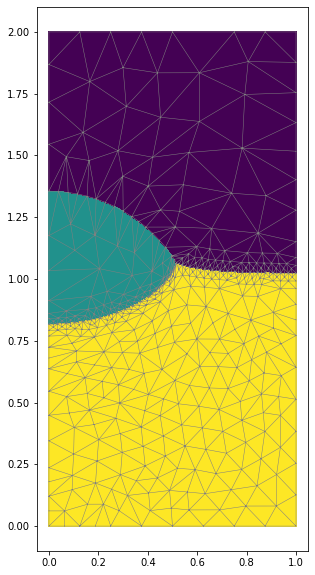

In [43]:
tmp = Function(q.function_space())
tmp.assign(-q)
ALE.move(mesh,q)
plt.figure(figsize=(10,10))
plot(subdomain_marker)
plot(mesh,linewidth=0.5)
ALE.move(mesh,tmp) 

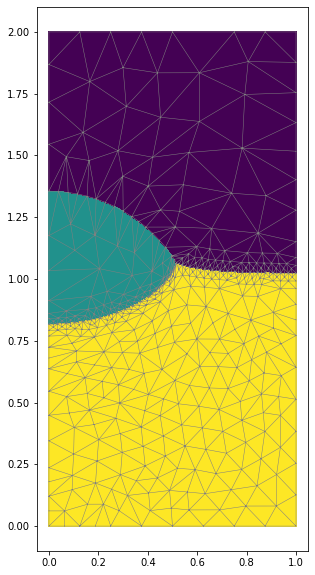

In [57]:
tmp = Function(q.function_space())
tmp.assign(-q)
ALE.move(mesh,q)
F = inv(Identity(2) + grad(q))

Fn = inner(F,F)


plt.figure(figsize=(10,10))
#c = plot(Fn)
#plt.colorbar(c)
plot(subdomain_marker)
plot(mesh,linewidth=0.5)
ALE.move(mesh,tmp) 

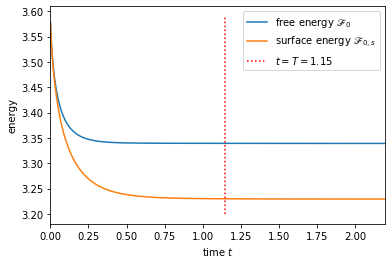

In [58]:
plt.figure()
#plt.plot(tims,E1+E3)
#E1.append(E_elast)
#E2.append(E_comp)
#E3.append(E_surf)
plt.plot(np.array(tims),np.array(E1)+np.array(E2)+np.array(E3),label='free energy $\mathscr{F}_0$')
plt.plot(np.array(tims),np.array(E3),label='surface energy $\mathscr{F}_{0,s}$')
plt.plot([1.15,1.15],[3.2,3.59],'r:',label='$t=T=1.15$')
plt.ylabel('energy')
plt.xlabel('time $t$')
plt.xlim([0,2.2])
plt.legend(loc='upper right')
plt.savefig('energy.png',dpi=300)

In [48]:
!ls

FSIc_G10_0_4_2
FSIc_G10_0_4_2_h5
FSIc_G10_1_1_2
FSIc_G10_1_1_2_h5
FSIc_G10_1_2_2
FSIc_G10_1_2_2_h5
FSIc_G10_1_4_1
FSIc_G10_1_4_1_h5
FSIc_G10_1_4_2
FSIc_G10_1_4_2_h5
FSIc_G10_1_4_3
FSIc_G10_1_4_3_h5
FSIc_G10_2_4_2
FSIc_G10_2_4_2_h5
FSIc_G10_3_4_2
FSIc_G10_3_4_2_h5
POSTPROCESSING_ERROR
POSTPROCESSING_G10_042
POSTPROCESSING_G10_242
POSTPROCESSING_G10_342
energy.png
postproguessing_sharp_Dirk_modified.py
sFSIc_G10_0_4_2
sFSIc_G10_0_4_2_h5
sFSIc_G10_1_1_2
sFSIc_G10_1_1_2_h5
sFSIc_G10_1_2_2
sFSIc_G10_1_2_2_h5
sFSIc_G10_1_4_1
sFSIc_G10_1_4_1_h5
sFSIc_G10_1_4_2
sFSIc_G10_1_4_2_h5
sFSIc_G10_1_4_3
sFSIc_G10_1_4_3_h5
sFSIc_G10_2_4_2
sFSIc_G10_2_4_2_h5
sFSIc_G10_3_4_2
sFSIc_G10_3_4_2_h5
sPOSTPROCESSING_ERROR
sPOSTPROCESSING_G10_042
sPOSTPROCESSING_G10_142
sPOSTPROCESSING_G10_242
sharp-interface-model-benchmark-stokes.ipynb
sharp-interface-model-benchmark.ipynb
sharp-interface-model-benchmarkX.ipynb
sharp-interface-model-fluid.ipynb
test.ipynb
xsFSIc_G10_0_2_2
xsFSIc_G10_0_2_2_h5
xsFSIc_G10_1_2_2
x

In [49]:
np.max(tims)

2.4150000499999709

In [62]:
!ls -1 |grep FSIc|grep -v h5

FSIc_G10_0_4_2
FSIc_G10_1_1_2
FSIc_G10_1_2_2
FSIc_G10_1_4_1
FSIc_G10_1_4_2
FSIc_G10_1_4_3
FSIc_G10_2_4_2
FSIc_G10_3_4_2
